<a href="https://colab.research.google.com/github/akashsonowal/content-based-book-recommendation/blob/main/book_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Darwin's bibliography**

Charles Darwin is one of the few universal figures of science. His most renowned work is without a doubt his "On the Origin of Species" published in 1859 which introduced the concept of natural selection. But Darwin wrote many other books on a wide range of topics, including geology, plants or his personal life. In this notebook, we will automatically detect how closely related his books are to each other.

To this purpose, we will develop the bases of a content-based book recommendation system, which will determine which books are close to each other based on how similar the discussed topics are. The methods we will use are commonly used in text- or documents-heavy industries such as legal, tech or customer support to perform some common task such as text classification or handling search engine queries.

Let's take a look at the books we'll use in our recommendation system.

In [ ]:
# Import library
import glob

# The books files are contained in this folder
folder = "/content/drive/MyDrive/Projects/02. Book Recommendations from Charles Darwin/datasets/"
# List all the .txt files and sort them alphabetically
files = sorted(glob.glob(folder + '*.txt'))
files

['/content/drive/MyDrive/Projects/02. Book Recommendations from Charles Darwin/datasets/Autobiography.txt',
 '/content/drive/MyDrive/Projects/02. Book Recommendations from Charles Darwin/datasets/CoralReefs.txt',
 '/content/drive/MyDrive/Projects/02. Book Recommendations from Charles Darwin/datasets/DescentofMan.txt',
 '/content/drive/MyDrive/Projects/02. Book Recommendations from Charles Darwin/datasets/DifferentFormsofFlowers.txt',
 '/content/drive/MyDrive/Projects/02. Book Recommendations from Charles Darwin/datasets/EffectsCrossSelfFertilization.txt',
 '/content/drive/MyDrive/Projects/02. Book Recommendations from Charles Darwin/datasets/ExpressionofEmotionManAnimals.txt',
 '/content/drive/MyDrive/Projects/02. Book Recommendations from Charles Darwin/datasets/FormationVegetableMould.txt',
 '/content/drive/MyDrive/Projects/02. Book Recommendations from Charles Darwin/datasets/FoundationsOriginofSpecies.txt',
 '/content/drive/MyDrive/Projects/02. Book Recommendations from Charles Dar

**Load the contents of each book into Python**

As a first step, we need to load the content of these books into Python and do some basic pre-processing to facilitate the downstream analyses. We call such a collection of texts a corpus. We will also store the titles for these books for future reference and print their respective length to get a gauge for their contents.

In [ ]:
# Import libraries
import re, os

# Initialize the object that will contain the texts and titles
txts = []
titles = []

for n in files:
    # Open each file
    f = open(n, encoding='utf-8-sig')
    # Remove all non-alpha-numeric characters
    content = re.sub('[\W_]+',' ',f.read())
    # Store the texts and titles of the books in two separate lists
    txts.append(content)
    titles.append(os.path.basename(n).replace(".txt", ""))

# Print the length, in characters, of each book
[len(t) for t in txts]

[123231,
 496068,
 1776539,
 617088,
 913713,
 624232,
 335920,
 523021,
 797401,
 901406,
 1047518,
 1010643,
 767492,
 1660866,
 298319,
 916267,
 1093567,
 1043499,
 341447,
 1149574]

**Find "On the Origin of Species"**

For the next parts of this analysis, we will often check the results returned by our method for a given book. For consistency, we will refer to Darwin's most famous book: "On the Origin of Species." Let's find to which index this book is associated.

In [ ]:
# Browse the list containing all the titles
for i in range(len(titles)):
    # Store the index if the title is "OriginofSpecies"
    if titles[i] == "OriginofSpecies":
        ori = i
        
# Print the stored index
print(ori)

15


**Tokenize the corpus**

As a next step, we need to transform the corpus into a format that is easier to deal with for the downstream analyses. We will tokenize our corpus, i.e., transform each text into a list of the individual words (called tokens) it is made of. To check the output of our process, we will print the first 20 tokens of "On the Origin of Species".

In [ ]:
# Define a list of stop words
stoplist = set('for a of the and to in to be which some is at that we i who whom show via may my our might as well'.split())

# Convert the text to lower case 
txts_lower_case = [t.lower() for t in txts]

# Transform the text into tokens 
txts_split = [t.split() for t in txts_lower_case]

# Remove tokens which are part of the list of stop words
texts = [[word for word in t if word not in stoplist] for t in txts_split]

# Print the first 20 tokens for the "On the Origin of Species" book
print(texts[ori][:20])

['on', 'origin', 'species', 'but', 'with', 'regard', 'material', 'world', 'can', 'least', 'go', 'so', 'far', 'this', 'can', 'perceive', 'events', 'are', 'brought', 'about']


**Stemming of the tokenized corpus**

If you have read On the Origin of Species, you will have noticed that Charles Darwin can use different words to refer to a similar concept. For example, the concept of selection can be described by words such as selection, selective, select or selects. This will dilute the weight given to this concept in the book and potentially bias the results of the analysis.

To solve this issue, it is a common practice to use a stemming process, which will group together the inflected forms of a word so they can be analysed as a single item: the stem. In our On the Origin of Species example, the words related to the concept of selection would be gathered under the select stem.

As we are analysing 20 full books, the stemming algorithm can take several minutes to run and, in order to make the process faster, we will directly load the final results from a pickle file and review the method used to generate it.

In [ ]:
# Load the Porter stemming function from the nltk package
import pickle
from nltk.stem import PorterStemmer

# Create an instance of a PorterStemmer object
porter = PorterStemmer()

# For each token of each text, we generated its stem 
texts_stem = [[porter.stem(token) for token in text] for text in texts]

# Save to pickle file
pickle.dump( texts_stem, open( "/content/drive/MyDrive/Projects/02. Book Recommendations from Charles Darwin/datasets/texts_stem.p", "wb" ) )

In [ ]:
# Load the stemmed tokens list from the pregenerated pickle file
texts_stem = pickle.load(open("/content/drive/MyDrive/Projects/02. Book Recommendations from Charles Darwin/datasets/texts_stem.p",'rb'))

# Print the 20 first stemmed tokens from the "On the Origin of Species" book
print(texts_stem[ori][:20])

['on', 'origin', 'speci', 'but', 'with', 'regard', 'materi', 'world', 'can', 'least', 'go', 'so', 'far', 'thi', 'can', 'perceiv', 'event', 'are', 'brought', 'about']


**Building a bag-of-words model**

Now that we have transformed the texts into stemmed tokens, we need to build models that will be useable by downstream algorithms.

First, we need to will create a universe of all words contained in our corpus of Charles Darwin's books, which we call a dictionary. Then, using the stemmed tokens and the dictionary, we will create bag-of-words models (BoW) of each of our texts. The BoW models will represent our books as a list of all uniques tokens they contain associated with their respective number of occurrences.

To better understand the structure of such a model, we will print the five first elements of one of the "On the Origin of Species" BoW model.

In [ ]:
# Load the functions allowing to create and use dictionaries
from gensim import corpora

# Create a dictionary from the stemmed tokens
dictionary = corpora.Dictionary(texts_stem)

# Create a bag-of-words model for each book, using the previously generated dictionary
bows = [dictionary.doc2bow(text) for text in texts_stem]

# Print the first five elements of the On the Origin of species' BoW model
print(bows[ori][:5])

[(0, 11), (5, 51), (6, 1), (8, 2), (21, 1)]


**The most common words of a given book**

The results returned by the bag-of-words model is certainly easy to use for a computer but hard to interpret for a human. It is not straightforward to understand which stemmed tokens are present in a given book from Charles Darwin, and how many occurrences we can find.

In order to better understand how the model has been generated and visualize its content, we will transform it into a DataFrame and display the 10 most common stems for the book "On the Origin of Species".

In [ ]:
# Import pandas to create and manipulate DataFrames
import pandas as pd

# Convert the BoW model for "On the Origin of Species" into a DataFrame
df_bow_origin = pd.DataFrame(bows[15])

# Add the column names to the DataFrame
df_bow_origin.columns=['index','occurrences']

# Add a column containing the token corresponding to the dictionary index
df_bow_origin['token'] = [dictionary[index] for index in df_bow_origin['index']]

# Sort the DataFrame by descending number of occurrences and print the first 10 values
print(df_bow_origin.sort_values(by = 'occurrences', ascending = False).head(10))

      index  occurrences  token
748    1168         2023   have
1119   1736         1558     on
1489   2288         1543  speci
892    1366         1480     it
239     393         1362     by
1128   1747         1201     or
125     218         1140    are
665    1043         1137   from
1774   2703         1000   with
1609   2452          962    thi


**Build a tf-idf model**

If it wasn't for the presence of the stem "speci", we would have a hard time to guess this BoW model comes from the On the Origin of Species book. The most recurring words are, apart from few exceptions, very common and unlikely to carry any information peculiar to the given book. We need to use an additional step in order to determine which tokens are the most specific to a book.

To do so, we will use a tf-idf model (term frequency–inverse document frequency). This model defines the importance of each word depending on how frequent it is in this text and how infrequent it is in all the other documents. As a result, a high tf-idf score for a word will indicate that this word is specific to this text.

After computing those scores, we will print the 10 words most specific to the "On the Origin of Species" book (i.e., the 10 words with the highest tf-idf score).



In [ ]:
# Load the gensim functions that will allow us to generate tf-idf models
from gensim.models import TfidfModel

# Generate the tf-idf model
model = TfidfModel(bows)

# Print the first 10 entries of the model for "On the Origin of Species"
print(model[bows[ori]][0:10])

[(8, 0.00020408683039616044), (21, 0.0005723177174474165), (23, 0.001714008058633542), (27, 0.0006466337090765656), (28, 0.0025710120879503125), (31, 0.000857004029316771), (35, 0.001016241827361025), (36, 0.001016241827361025), (51, 0.0008878482198272165), (54, 0.00203248365472205)]


**The results of the tf-idf model**

Once again, the format of those results is hard to interpret for a human. Therefore, we will transform it into a more readable version and display the 10 most specific words for the "On the Origin of Species" book.

In [ ]:
# Convert the tf-idf model for "On the Origin of Species" into a DataFrame
df_tfidf = pd.DataFrame(model[bows[ori]])

# Name the columns of the DataFrame id and score
df_tfidf.columns=['id','score']

# Add the tokens corresponding to the numerical indices for better readability
df_tfidf['token'] = [ dictionary[index] for index in df_tfidf['id']]

# Sort the DataFrame by descending tf-idf score and print the first 10 rows.
print(df_tfidf.sort_values(by = 'score', ascending = False).head(10))

         id     score      token
880    2164  0.327823     select
3103  10108  0.204162     pigeon
128     369  0.197968      breed
2985   9395  0.167705     migrat
947    2325  0.148371     steril
285     752  0.146172     domest
504    1255  0.128433     hybrid
371     966  0.127694     fertil
3840  16046  0.124547    gärtner
3536  12729  0.121348  naturalis


**Compute distance between texts**

The results of the tf-idf algorithm now return stemmed tokens which are specific to each book. We can, for example, see that topics such as selection, breeding or domestication are defining "On the Origin of Species" (and yes, in this book, Charles Darwin talks quite a lot about pigeons too). Now that we have a model associating tokens to how specific they are to each book, we can measure how related to books are between each other.

To this purpose, we will use a measure of similarity called cosine similarity and we will visualize the results as a distance matrix, i.e., a matrix showing all pairwise distances between Darwin's books.

In [ ]:
# Load the library allowing similarity computations
from gensim import similarities
from IPython.display import display, HTML

# Compute the similarity matrix (pairwise distance between all texts)
sims = similarities.MatrixSimilarity(model[bows])

# Transform the resulting list into a dataframe
sim_df = pd.DataFrame(list(sims))

# Add the titles of the books as columns and index of the dataframe
sim_df.columns = titles
sim_df.index = titles

# Print the resulting matrix
display(HTML(sim_df.to_html()))

,Autobiography,CoralReefs,DescentofMan,DifferentFormsofFlowers,EffectsCrossSelfFertilization,ExpressionofEmotionManAnimals,FormationVegetableMould,FoundationsOriginofSpecies,GeologicalObservationsSouthAmerica,InsectivorousPlants,LifeandLettersVol1,LifeandLettersVol2,MonographCirripedia,MonographCirripediaVol2,MovementClimbingPlants,OriginofSpecies,PowerMovementPlants,VariationPlantsAnimalsDomestication,VolcanicIslands,VoyageBeagle
Autobiography,1.000000,0.049722,0.080789,0.066615,0.077006,0.089345,0.041182,0.058990,0.030679,0.014945,0.399534,0.220023,0.005854,0.008456,0.022999,0.101199,0.016059,0.048989,0.038630,0.184288
CoralReefs,0.049722,1.000000,0.009516,0.001980,0.001936,0.005062,0.029445,0.022066,0.060744,0.002284,0.031211,0.017772,0.006321,0.010497,0.001534,0.039200,0.002686,0.011383,0.057402,0.267414
DescentofMan,0.080789,0.009516,1.000000,0.072792,0.029997,0.148642,0.027106,0.135001,0.009628,0.009468,0.060040,0.080569,0.053426,0.042937,0.005157,0.267734,0.011267,0.228437,0.007885,0.123902
DifferentFormsofFlowers,0.066615,0.001980,0.072792,1.000000,0.391788,0.006545,0.010621,0.039993,0.002855,0.007487,0.016188,0.046692,0.009403,0.005451,0.008165,0.129152,0.018831,0.049405,0.002624,0.013213
EffectsCrossSelfFertilization,0.077006,0.001936,0.029997,0.391788,1.000000,0.006871,0.032270,0.040248,0.002247,0.006763,0.019609,0.046567,0.003218,0.002957,0.014939,0.146700,0.039520,0.054458,0.002183,0.017183
ExpressionofEmotionManAnimals,0.089345,0.005062,0.148642,0.006545,0.006871,1.000000,0.021066,0.047103,0.005246,0.011461,0.065391,0.049333,0.016802,0.029644,0.005942,0.063242,0.011234,0.082567,0.005595,0.099124
FormationVegetableMould,0.041182,0.029445,0.027106,0.010621,0.032270,0.021066,1.000000,0.021468,0.067712,0.035498,0.028357,0.023943,0.019864,0.023915,0.038823,0.049519,0.039911,0.032647,0.059299,0.098331
FoundationsOriginofSpecies,0.058990,0.022066,0.135001,0.039993,0.040248,0.047103,0.021468,1.000000,0.027300,0.005995,0.057749,0.054703,0.007650,0.010762,0.003971,0.322736,0.008712,0.196578,0.017528,0.089075
GeologicalObservationsSouthAmerica,0.030679,0.060744,0.009628,0.002855,0.002247,0.005246,0.067712,0.027300,1.000000,0.006844,0.028691,0.012241,0.009260,0.023486,0.002046,0.052878,0.003450,0.013737,0.372272,0.259514
InsectivorousPlants,0.014945,0.002284,0.009468,0.007487,0.006763,0.011461,0.035498,0.005995,0.006844,1.000000,0.006062,0.016549,0.019091,0.019657,0.249011,0.014982,0.022841,0.010321,0.008526,0.014758


**The book most similar to "On the Origin of Species"**

We now have a matrix containing all the similarity measures between any pair of books from Charles Darwin! We can now use this matrix to quickly extract the information we need, i.e., the distance between one book and one or several others.

As a first step, we will display which books are the most similar to "On the Origin of Species," more specifically we will produce a bar chart showing all books ranked by how similar they are to Darwin's landmark work.

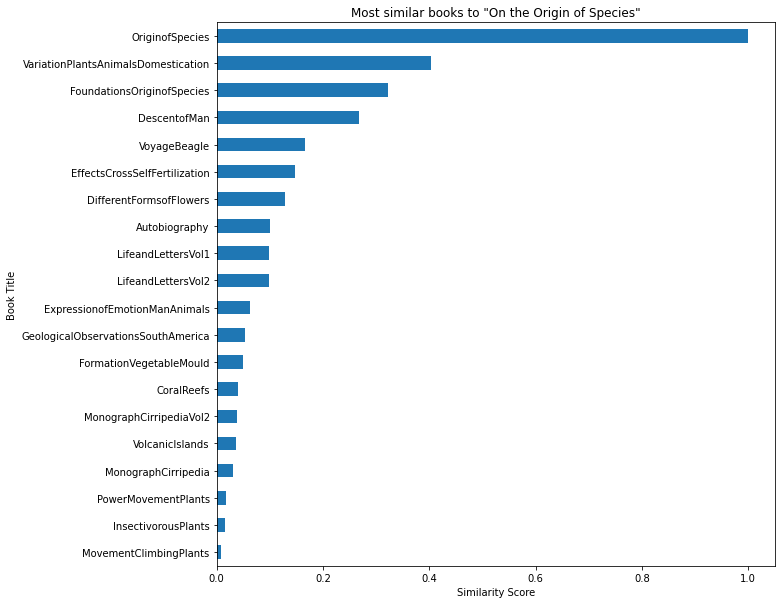

In [ ]:
# This is needed to display plots in a notebook
%matplotlib inline

# Import libraries
import matplotlib.pyplot as plt

# Select the column corresponding to "On the Origin of Species" and 
v = sim_df['OriginofSpecies']

fig = plt.figure(figsize=(10,10))
# Sort by ascending scores
v_sorted = v.sort_values()

# Plot this data has a horizontal bar plot
v_sorted.plot.barh(x='lab', y='val', rot=0)

# Modify the axes labels and plot title for a better readability
plt.xlabel('Similarity Score')
plt.ylabel('Book Title')
plt.title('Most similar books to "On the Origin of Species"')
plt.show()

**Which books have similar content?**

This turns out to be extremely useful if we want to determine a given book's most similar work. For example, we have just seen that if you enjoyed "On the Origin of Species," you can read books discussing similar concepts such as "The Variation of Animals and Plants under Domestication" or "The Descent of Man, and Selection in Relation to Sex." If you are familiar with Darwin's work, these suggestions will likely seem natural to you. Indeed, On the Origin of Species has a whole chapter about domestication and The Descent of Man, and Selection in Relation to Sex applies the theory of natural selection to human evolution. Hence, the results make sense.

However, we now want to have a better understanding of the big picture and see how Darwin's books are generally related to each other (in terms of topics discussed). To this purpose, we will represent the whole similarity matrix as a dendrogram, which is a standard tool to display such data. This last approach will display all the information about book similarities at once. For example, we can find a book's closest relative but, also, we can visualize which groups of books have similar topics (e.g., the cluster about Charles Darwin personal life with his autobiography and letters). If you are familiar with Darwin's bibliography, the results should not surprise you too much, which indicates the method gives good results. Otherwise, next time you read one of the author's book, you will know which other books to read next in order to learn more about the topics it addressed.

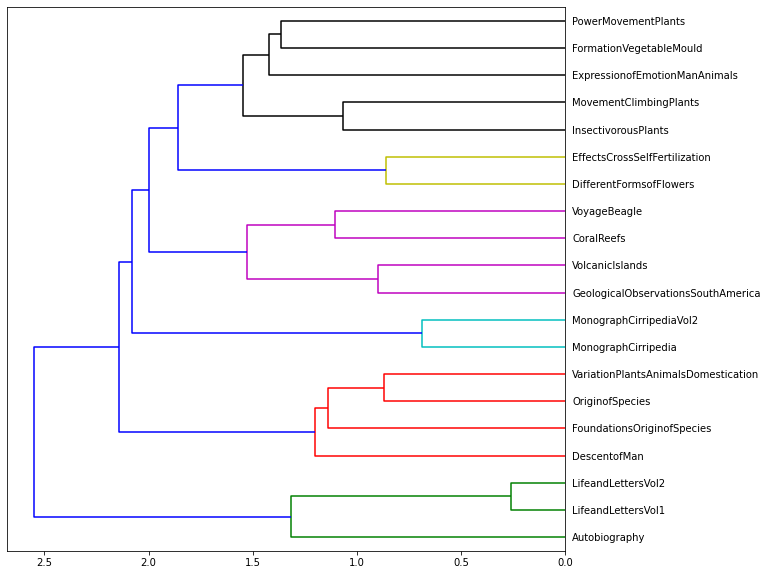

In [ ]:
# Import libraries
from scipy.cluster import hierarchy

# Compute the clusters from the similarity matrix,
# using the Ward variance minimization algorithm
Z = hierarchy.linkage(sim_df,'ward')

# Create the figure and set it's size.
fig = plt.figure(figsize=(10,10))

# Display this result as a horizontal dendrogram
a = hierarchy.dendrogram(Z,leaf_font_size=10, labels=sim_df.index, orientation="left")

**Summary**

We have tokenize our corpus, i.e., transform each text into a list of the individual words (called tokens) it is made of.

We built a tf-idf model (term frequency–inverse document frequency) which defines the importance of each word depending on how frequent it is in this text and how infrequent it is in all the other documents. Note: A high tf-idf score for a word will indicate that this word is specific to this text.

We used cosine similarity and visualized the results as a distance matrix, i.e., a matrix showing all pairwise distances between Darwin's books to determine the most similar books to "Origin of the species".

Finally, we studied how Darwin's books are generally related to each other (in terms of topics discussed)by representing the similarity matrix as a dendrogram.